In [1]:
import pandas as pd
from scipy import stats
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from statsmodels.nonparametric.kernel_density import KDEMultivariate
# from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupShuffleSplit
#from sklearn.model_selection import train_test_split

import seaborn as sns
import numpy as np
import re
import os


In [2]:
%load_ext autoreload
%autoreload 2
    
from helpers.utils import _qq_stats_text
from helpers.utils import scree
from helpers.utils import learn_kde
from helpers.utils import score_with_kdes
from helpers.utils import reshape_to_cmat, _site_slice
import helpers.utils 

In [3]:
import sys; print(sys.executable)

plt.rcParams.update({"font.size": 9})

/Users/gc3045/miniconda3/bin/python


In [4]:
plot_dir = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/plots/"
out_dir = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/inputs/"

barcoded_fname = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/PEtracer raw data/barcoded_tracing_alleles.csv"
colony_fname = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/PEtracer raw data/colony_alleles.csv"
validation_fname = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/PEtracer raw data/preedited_merfish_invitro_alleles.csv"

First look at `colony_df`. For each cassette, we have three target sites. The features are in columns: r25-r51. First, I need to extract these features and then rotate them to long format, so that I have a row for every (cellBC, intID, target_site). Note that the order of target sites is: `RNF2, HEK3, EMX1` in the paper, but we let the order be `HEK3`, `EMX1`, `RNF2` according to the order given in `validation_df`. This was also checked using classification error. 

Recall that NaN is the unedited state!

#### Process inputs

In [5]:
barcoded_df = pd.read_csv(barcoded_fname)
colony_df = pd.read_csv(colony_fname)
validation_df = pd.read_csv(validation_fname)

In [6]:
validation_df.columns

Index(['intID', 'cellBC', 'HEK3', 'EMX1', 'RNF2', 'spot', 'x', 'y', 'z',
       'global_x', 'global_y', 'global_z', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6',
       'r7', 'r8', 'r9', 'r10', 'r11', 'r12', 'r13', 'r14', 'r15', 'r16',
       'r17', 'r18', 'r19', 'r20', 'r21', 'r25', 'r26', 'r27', 'r28', 'r29',
       'r30', 'r31', 'r32', 'r33', 'r34', 'r35', 'r36', 'r37', 'r38', 'r39',
       'r40', 'r41', 'r42', 'r43', 'r44', 'r45', 'r46', 'r47', 'r48', 'r49',
       'r50', 'r51', 'intBC_dist', 'intBC_intensity', 'intBC_snr', 'HEK3_prob',
       'HEK3_intensity', 'HEK3_snr', 'EMX1_prob', 'EMX1_intensity', 'EMX1_snr',
       'RNF2_prob', 'RNF2_intensity', 'RNF2_snr', 'cell', 'cell_dist',
       'sample', 'clone', 'whitelist', 'RNF2_actual', 'HEK3_actual',
       'EMX1_actual', 'RNF2_brightest', 'HEK3_brightest', 'EMX1_brightest'],
      dtype='object')

In [7]:
validation_df['clone'].value_counts()

clone
1    22473
2    12682
4     5886
3     2894
Name: count, dtype: int64

In [8]:
validation_df = validation_df.fillna("unedited")
dfw = validation_df.copy()

In [9]:
np.mean(dfw[dfw['clone'] == 3]['HEK3'].isna())

np.float64(0.0)

In [10]:
id_cols    = ["cellBC", "intID", "clone", "x", "y", "z"]
site_cols  = ["HEK3", "EMX1", "RNF2"]
actual_cols    = [f"{s}_actual"    for s in site_cols]   # sequencing ground truth
brightest_cols = [f"{s}_brightest" for s in site_cols]   # brightest call
prob_cols      = [f"{s}_prob"      for s in site_cols]   # per-site probability (PETRacer)
# r25..r51 (27 features total)
rcols = [c for c in dfw.columns if re.fullmatch(r"r(?:2[5-9]|3\d|4\d|5[01])", c)]
rcols_sorted = sorted(rcols, key=lambda s: int(s[1:]))

In [11]:
assert set(site_cols).issubset(dfw.columns), "Missing site columns"
assert all(c in dfw.columns for c in actual_cols), "Missing *_actual"
assert all(c in dfw.columns for c in brightest_cols), "Missing *_brightest"
assert all(c in dfw.columns for c in prob_cols), "Missing *_prob"
assert len(rcols_sorted) == 27, f"Expected 27 r-features, found {len(rcols_sorted)}"

In [12]:
pieces = [
    _site_slice(dfw, "HEK3", 0, id_cols),
    _site_slice(dfw, "EMX1", 1, id_cols),
    _site_slice(dfw, "RNF2", 2, id_cols),
]

long_df = pd.concat(pieces, axis=0, ignore_index=True)

Note this helper function is specific to PEtracer. Assumes the features are r25-r51.
['r25', 'r26', 'r27', 'r28', 'r29', 'r30', 'r31', 'r32', 'r33'] [True, True, True, True, True, True, True, True, True]
Note this helper function is specific to PEtracer. Assumes the features are r25-r51.
['r34', 'r35', 'r36', 'r37', 'r38', 'r39', 'r40', 'r41', 'r42'] [True, True, True, True, True, True, True, True, True]
Note this helper function is specific to PEtracer. Assumes the features are r25-r51.
['r43', 'r44', 'r45', 'r46', 'r47', 'r48', 'r49', 'r50', 'r51'] [True, True, True, True, True, True, True, True, True]


In [13]:
assert long_df.shape[0] == (validation_df.shape[0] * 3)

In [14]:
sum(long_df['seq_state'].isna())

0

In [15]:
sum(validation_df['HEK3_actual'].isna()) + sum(validation_df['RNF2_actual'].isna()) + sum(validation_df['EMX1_actual'].isna())

0

In [16]:
feature_cols = [f"feature_{j}" for j in range(9)]

In [17]:
len(feature_cols)

9

In [18]:
truth = long_df["seq_state"]
pet   = long_df["pet_state"]
brite = long_df["brightest_state"]

mask_pet   = truth.notna() & pet.notna()
mask_brite = truth.notna() & brite.notna()

pet_wrong_pct   = 100 * (pet[mask_pet] != truth[mask_pet]).mean()
brite_wrong_pct = 100 * (brite[mask_brite] != truth[mask_brite]).mean()

print(f"PETRacer discriminative classifier is wrong: {pet_wrong_pct:.3f}% of the time (n={int(mask_pet.sum())})")
print(f"Brightest fluorescence is wrong: {brite_wrong_pct:.3f}% of the time (n={int(mask_brite.sum())})")

PETRacer discriminative classifier is wrong: 1.783% of the time (n=131805)
Brightest fluorescence is wrong: 2.261% of the time (n=131805)


In [19]:
long_df['clone'].unique()

array([2, 1, 4, 3])

To-do: (Reproducing Figure 2 from the paper)
- ~~Look at the non-parametric nature of the data~~
- ~~Z-normalize and compute scree plot.~~
- ~~Split 70/30 train/test. Train 27 KDEs.~~
- Report classification error.
- Split into Clone 4 (most sites). Score test samples. 
- Run LAML-Pro.
- Plot logdensity convergence.
- Report genotype call accuracy vs. genotype sequencing accuracy.
- Look at alignment distance vs. genotype call accuracy. 
- Look at places where the "brightest" intensity pixel was not the correct state.

#### Evaluate non-parametric nature of the data

In [20]:
df = long_df

In [21]:
out_dir = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/plots/petracer_nonparametric/"

In [22]:
scaler = StandardScaler()
X = scaler.fit_transform(df[feature_cols].values)   # shape: (n_samples, n_features)

In [23]:
for site in df["target_site"].dropna().unique():
    site_mask = df["target_site"].eq(site)
    labels = df.loc[site_mask, "seq_state"].dropna().unique()

    for lab in labels:
        m = site_mask & df["seq_state"].eq(lab)       # mask over df rows
        idx = m.to_numpy()
        Z = X[idx, :]                                  # (n_lab, 9)
        if Z.shape[0] == 0:
            continue

        # 3x3 grid for 9 features
        fig, axes = plt.subplots(3, 3, figsize=(10, 9), dpi=150)
        axes = axes.ravel()

        for j in range(9):
            ax = axes[j]
            stats.probplot(Z[:, j], dist="norm", plot=ax)
            ax.set_title(feature_cols[j], fontsize=9)
            ax.set_xlabel(""); ax.set_ylabel("")
            # If you have this helper already:
            try:
                ax.text(0.02, 0.98, _qq_stats_text(Z[:, j]),
                        transform=ax.transAxes, fontsize=8, family="monospace",
                        va="top", ha="left")
            except NameError:
                pass  # skip annotation if helper not defined

        # Hide any remaining axes (paranoia; should be none for 9 features)
        for k in range(9, len(axes)):
            axes[k].axis("off")

        fig.suptitle(f"QQ plots (z-norm) — site={site}, label={lab} (n={Z.shape[0]})",
                     fontsize=12)
        plt.tight_layout(rect=[0, 0, 1, 0.96])

        safe_lab = re.sub(r"[^A-Za-z0-9._-]+", "_", str(lab))
        pdf = os.path.join(out_dir, f"qq_site_{site}_{safe_lab}.pdf")
        fig.savefig(pdf, bbox_inches="tight")
        plt.close(fig)

#### Intrinsic dimensionality of data

In [78]:
df = long_df.copy()

In [79]:
# print("Training data proportions")
# pd.DataFrame(df['seq_state'].value_counts(normalize=True))

In [81]:
gss = GroupShuffleSplit(test_size=0.30, random_state=0)
train_idx, test_idx = next(gss.split(df, groups=df["cellBC"]))
df_train = df.iloc[train_idx].copy()
df_test = df.iloc[test_idx].copy()

In [82]:
scaler = StandardScaler()
X_train = scaler.fit_transform(df_train[feature_cols].values)
X_test = scaler.transform(df_test[feature_cols].values)

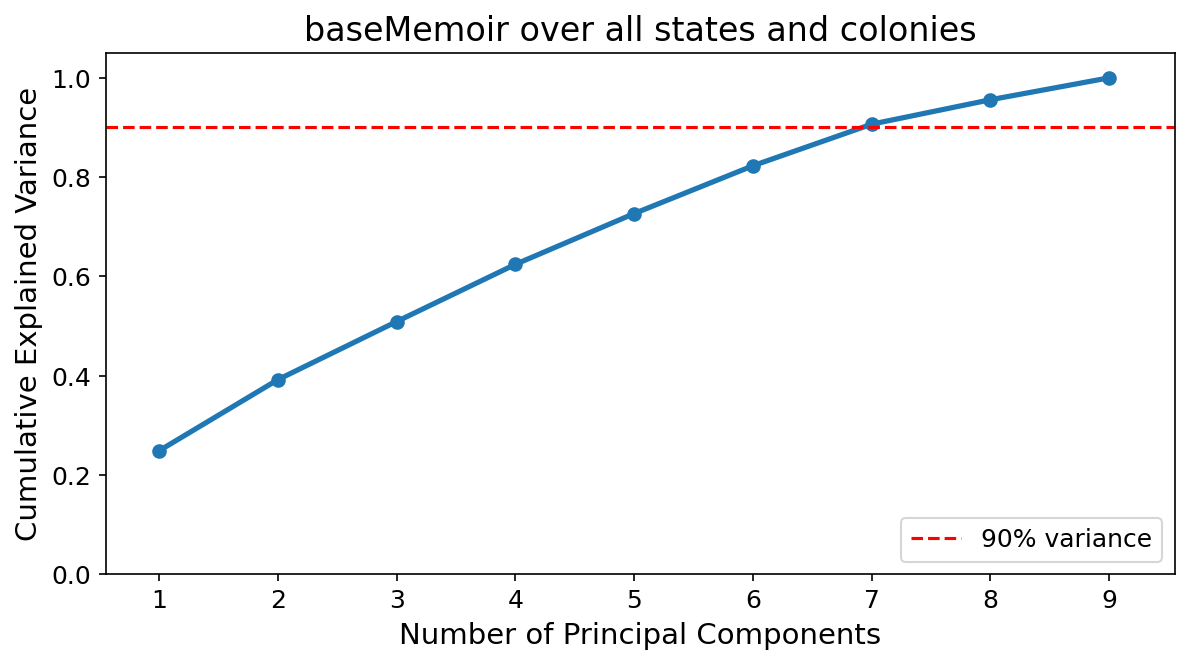

In [83]:
vr, cv = scree(X_train, out=f"{plot_dir}/PEtracer_scree.pdf")

In [84]:
df_train['clone'].value_counts(normalize=True)

clone
1    0.512037
2    0.291175
4    0.132614
3    0.064174
Name: proportion, dtype: float64

In [85]:
df_test['clone'].value_counts(normalize=True)

clone
1    0.510240
2    0.282646
4    0.137204
3    0.069911
Name: proportion, dtype: float64

#### Evaluate z-norm or pca rotation of data

In [89]:
X_train

array([[-0.20452074,  0.49328513,  0.19053052, ...,  2.81600958,
         0.2325087 , -0.24116432],
       [-0.27639185, -0.12806832, -0.18303128, ...,  1.57827757,
        -0.19069163, -0.23808071],
       [ 0.32852317,  0.93116249,  0.02981231, ...,  7.77640728,
         0.71861783, -0.16639038],
       ...,
       [ 0.18544672, -0.31000314, -0.26990628, ..., -0.29205171,
        -0.35225131, -0.26274893],
       [ 1.23689524, -0.17046805, -0.22212484, ...,  0.23258758,
        -0.27266323, -0.27354091],
       [ 0.44165404, -0.35702859, -0.29596805, ..., -0.25795994,
        -0.34986838, -0.2704573 ]], shape=(92841, 9))

In [86]:
pca = PCA(n_components=9, random_state=0)
Z_train = pca.fit_transform(X_train)
Z_test  = pca.transform(X_test)

In [87]:
df_train['cellBC'].nunique(), df_test['cellBC'].nunique()

(4724, 2025)

In [88]:
# Build KDEs per (site, seq_state) on TRAIN only
all_kde_dict_X, all_kde_dict_Z = {}, {}

site_order = df_train["target_site"].dropna().unique()   
min_pts = 2                                              

for site in site_order:
    all_kde_dict_X[site] = {}
    all_kde_dict_Z[site] = {}

    site_mask = df_train["target_site"].eq(site)
    labels = df_train.loc[site_mask, "seq_state"].dropna().unique()

    for lab in labels:
        m_train = site_mask & df_train["seq_state"].eq(lab)   # boolean mask over df_train rows
        n = int(m_train.sum())
        if n < min_pts:
            continue

        # slice rows from the *arrays* aligned to df_train
        X_block = X_train[m_train.values, :]   # raw feature space (scaled)
        Z_block = Z_train[m_train.values, :]   # PCA space

        kde_X = learn_kde(X_block)
        print(f"{site} {lab} [n={n}] kde(X) IMSE={kde_X.imse(kde_X.bw):.4g}")
        all_kde_dict_X[site][lab] = kde_X

        kde_Z = learn_kde(Z_block)
        print(f"{site} {lab} [n={n}] kde(Z) IMSE={kde_Z.imse(kde_Z.bw):.4g}")
        all_kde_dict_Z[site][lab] = kde_Z


HEK3 CTCTC [n=3902] kde(X) IMSE=-1930
HEK3 CTCTC [n=3902] kde(Z) IMSE=-78.45
HEK3 CTTTG [n=7670] kde(X) IMSE=-1874
HEK3 CTTTG [n=7670] kde(Z) IMSE=-18.84
HEK3 ATCAA [n=4088] kde(X) IMSE=-273.5
HEK3 ATCAA [n=4088] kde(Z) IMSE=-0.2184
HEK3 unedited [n=6090] kde(X) IMSE=-1.41e+05
HEK3 unedited [n=6090] kde(Z) IMSE=-4.412e+04
HEK3 GATAG [n=3898] kde(X) IMSE=-282.5
HEK3 GATAG [n=3898] kde(Z) IMSE=-1.604
HEK3 AATCG [n=946] kde(X) IMSE=-3581
HEK3 AATCG [n=946] kde(Z) IMSE=-2.385
HEK3 GCAAG [n=2936] kde(X) IMSE=-1555
HEK3 GCAAG [n=2936] kde(Z) IMSE=-6.854
HEK3 ATTTA [n=460] kde(X) IMSE=-64.12
HEK3 ATTTA [n=460] kde(Z) IMSE=-9.902
HEK3 GCGCC [n=957] kde(X) IMSE=-1227
HEK3 GCGCC [n=957] kde(Z) IMSE=-0.01956
EMX1 AGTAC [n=3837] kde(X) IMSE=-2253
EMX1 AGTAC [n=3837] kde(Z) IMSE=-0.6496
EMX1 ACAAT [n=5551] kde(X) IMSE=-328.1
EMX1 ACAAT [n=5551] kde(Z) IMSE=-0.2654
EMX1 CCTTT [n=4506] kde(X) IMSE=-1.636e+04
EMX1 CCTTT [n=4506] kde(Z) IMSE=-240.7
EMX1 unedited [n=6090] kde(X) IMSE=-2.08e+05
EMX1 uned

#### Evaluate classification accuracy

In [33]:
df = long_df.copy()

In [34]:
gss = GroupShuffleSplit(test_size=0.30, random_state=42)
train_idx, test_idx = next(gss.split(df, groups=df["cellBC"]))
df_train = df.iloc[train_idx].copy()
df_test = df.iloc[test_idx].copy()

In [35]:
scaler = StandardScaler()
X_train = scaler.fit_transform(df_train[feature_cols].values)
X_test = scaler.transform(df_test[feature_cols].values)

In [36]:
sites = df_test["target_site"].dropna().unique()

preds_X_full = pd.DataFrame(index=df_test.index, columns=["pred_label","argmax_idx","argmax_logpdf"])
preds_Z_full = pd.DataFrame(index=df_test.index, columns=["pred_label","argmax_idx","argmax_logpdf"])

# Optional: store per-site scores with site-prefixed column names
scores_X_tables = []
scores_Z_tables = []

for site in sites:
    print(site)
    m = df_test["target_site"].eq(site).values
    idx = df_test.index[m]

    # --- X space ---
    preds_X, scores_X = score_with_kdes(X_test[m, :], all_kde_dict_X[site])
    # place preds into full frame
    preds_X.index = idx
    preds_X_full.loc[idx, :] = preds_X[["pred_label","argmax_idx","argmax_logpdf"]].to_numpy()
    # keep scores with site prefix to avoid column name collisions
    scores_X.index = idx
    scores_X = scores_X.add_prefix(f"{site}::")
    scores_X_tables.append(scores_X)
    print("Scored X...")

    # --- Z space ---
    preds_Z, scores_Z = score_with_kdes(Z_test[m, :], all_kde_dict_Z[site])
    preds_Z.index = idx
    preds_Z_full.loc[idx, :] = preds_Z[["pred_label","argmax_idx","argmax_logpdf"]].to_numpy()
    scores_Z.index = idx
    scores_Z = scores_Z.add_prefix(f"{site}::")
    scores_Z_tables.append(scores_Z)
    print("Scored Z...")


HEK3
Scored X...
Scored Z...
EMX1
Scored X...
Scored Z...
RNF2
Scored X...
Scored Z...


In [37]:
# Clean types
for df_ in (preds_X_full, preds_Z_full):
    df_["argmax_idx"] = pd.to_numeric(df_["argmax_idx"], errors="coerce")
    df_["argmax_logpdf"] = pd.to_numeric(df_["argmax_logpdf"], errors="coerce")

# Merge with metadata if you want a single output table
out = (
    df_test[["intID","target_site","seq_state","brightest_state", "pet_state"]]
    .join(preds_X_full.add_prefix("X_"))
    .join(preds_Z_full.add_prefix("Z_"))
)

In [38]:
out

,intID,target_site,seq_state,brightest_state,pet_state,X_pred_label,X_argmax_idx,X_argmax_logpdf,Z_pred_label,Z_argmax_idx,Z_argmax_logpdf
3,intID1011,HEK3,CTCTC,CTCTC,CTCTC,CTCTC,0,6.603799,CTCTC,0,3.820014
8,intID1011,HEK3,CTCTC,CTCTC,CTCTC,CTCTC,0,6.318518,CTCTC,0,4.068828
16,intID1011,HEK3,CTCTC,CTCTC,CTCTC,CTCTC,0,7.988184,CTCTC,0,5.032489
22,intID1011,HEK3,CTCTC,CTCTC,CTCTC,CTCTC,0,8.083751,CTCTC,0,4.949856
23,intID1011,HEK3,CTCTC,CTCTC,CTCTC,CTCTC,0,6.721019,CTCTC,0,2.136251
...,...,...,...,...,...,...,...,...,...,...,...
131778,intID974,RNF2,TTCCT,TTCCT,TTCCT,TTCCT,5,-2.004493,TTCCT,5,-3.130625
131792,intID974,RNF2,TTCCT,TTCCT,TTCCT,TTCCT,5,5.877723,ACTTA,8,5.564079
131796,intID974,RNF2,TTCCT,TTCCT,TTCCT,TTCCT,5,4.925674,TTCCT,5,1.301868
131799,intID974,RNF2,TTCCT,TTCCT,TTCCT,TTCCT,5,5.721704,ACAGT,7,3.681458


In [39]:
def accuracy(y_true, y_pred):
    mask = y_true.notna() & y_pred.notna()
    return (y_true[mask] == y_pred[mask]).mean()

methods = {
    "brightest_state": "brightest_state_acc",
    "pet_state": "pet_state_acc",
    "X_pred_label": "X_pred_label_acc",
    "Z_pred_label": "Z_pred_label_acc",
}

acc_by_site = (
    out.groupby("target_site", dropna=False)
    .apply(lambda g: pd.Series({
        new_name: accuracy(g["seq_state"], g[col])
        for col, new_name in methods.items()
    }))
    .reset_index()
)

overall = {
    new_name: accuracy(out["seq_state"], out[col])
    for col, new_name in methods.items()
}
overall_row = pd.DataFrame([{"target_site": "Total", **overall}])

acc_by_site_with_total = pd.concat([acc_by_site, overall_row], ignore_index=True)
acc_by_site_with_total

/var/folders/jx/nl4vbs_j5qdbrq_3w4lqgcwc0000gn/T/ipykernel_46051/223429458.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,target_site,brightest_state_acc,pet_state_acc,X_pred_label_acc,Z_pred_label_acc
0,EMX1,0.974345,0.978174,0.771941,0.668249
1,HEK3,0.971818,0.980548,0.852274,0.741538
2,RNF2,0.986292,0.987517,0.808393,0.703783
3,Total,0.977485,0.982080,0.810869,0.704523


### Final stage: reformat and save test data (Clone 2)

In [40]:
print("Ready to add in kde preds and scores!")

Ready to add in kde preds and scores!


In [41]:
df_clean = df_test.copy()

In [42]:
df_clean['kde_pred_string'] = preds_X_full['pred_label']

all_idx = [x.index for x in scores_X_tables]

for i, idx in enumerate(all_idx):
    dupes = idx[idx.duplicated()]
    if len(dupes):
        print(f"[warn] scores_X_tables[{i}] has {len(dupes)} duplicate indices!")
    else:
        print(f"[ok] scores_X_tables[{i}] indices are unique.")

[ok] scores_X_tables[0] indices are unique.
[ok] scores_X_tables[1] indices are unique.
[ok] scores_X_tables[2] indices are unique.


In [43]:
all_idx = pd.Index([]).append([x.index for x in scores_X_tables])

# check equality with df_clean
print("same length:", len(all_idx) == len(df_clean))
print("same members:", set(all_idx) == set(df_clean.index))

same length: True
same members: True


/var/folders/jx/nl4vbs_j5qdbrq_3w4lqgcwc0000gn/T/ipykernel_46051/210554016.py:1: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  all_idx = pd.Index([]).append([x.index for x in scores_X_tables])


In [44]:
site_states = {}

for df in scores_X_tables:
    for c in df.columns:
        if "::state" not in c:
            continue
        site, label = c.split("::state")
        label = label.replace("_prob", "")
        site_states.setdefault(site, set()).add(label)

# --- Build the codebook ---
rows = []
for site, labels in site_states.items():
    # ensure 'unedited' is 0, others get 1..8 sorted alphabetically
    labels_sorted = sorted([l for l in labels if l != "unedited"])
    ordered = ["unedited"] + labels_sorted
    for i, lbl in enumerate(ordered):
        rows.append({"site": site, "label": lbl, "code": i})

label_codebook = pd.DataFrame(rows).sort_values(["site", "code"], ignore_index=True)
print(label_codebook)
label_codebook.to_csv(out_dir + "/label_codebook.csv", index=False) 

    site     label  code
0   EMX1  unedited     0
1   EMX1     ACAAT     1
2   EMX1     AGTAC     2
3   EMX1     ATCAA     3
4   EMX1     ATTCG     4
5   EMX1     CCCTA     5
6   EMX1     CCGAT     6
7   EMX1     CCTTT     7
8   EMX1     GGACA     8
9   HEK3  unedited     0
10  HEK3     AATCG     1
11  HEK3     ATCAA     2
12  HEK3     ATTTA     3
13  HEK3     CTCTC     4
14  HEK3     CTTTG     5
15  HEK3     GATAG     6
16  HEK3     GCAAG     7
17  HEK3     GCGCC     8
18  RNF2  unedited     0
19  RNF2     ACAGT     1
20  RNF2     ACTCC     2
21  RNF2     ACTTA     3
22  RNF2     GTTCA     4
23  RNF2     TATAT     5
24  RNF2     TCCAA     6
25  RNF2     TGCCA     7
26  RNF2     TTCCT     8


In [45]:
# make sure df_clean has 9 columns ready (will fill in order)
for i in range(9):
    col = f"state{i}_prob"
    if col not in df_clean.columns:
        df_clean[col] = pd.NA  # initialize

for site, df_scores in zip(sites, scores_X_tables):
    # ensure we’re using the actual indices from this score table
    idx = df_scores.index  

    # mapping: label -> code
    site_map = (
        label_codebook.query("site == @site")
        .set_index("label")["code"]
        .to_dict()
    )

    for col in df_scores.columns:
        m = re.match(r"(.+)::state(.+)_prob", col)
        if not m:
            continue
        _, label = m.groups()
        code = site_map.get(label.strip())
        if code is None:
            continue

        target_col = f"state{code}_prob"
        df_clean.loc[idx, target_col] = df_scores[col].values
        
state_cols = sorted(
    [c for c in df_clean.columns if re.match(r"state\d+_prob", c)],
    key=lambda x: int(re.search(r"\d+", x).group())
)
other_cols = [c for c in df_clean.columns if c not in state_cols]
df_clean = df_clean[other_cols + state_cols]

df_clean

,cellBC,intID,clone,x,y,z,target_site,pet_state,seq_state,brightest_state,...,kde_pred_string,state0_prob,state1_prob,state2_prob,state3_prob,state4_prob,state5_prob,state6_prob,state7_prob,state8_prob
3,4T1_preedited-1153,intID1011,2,2189,647,23,HEK3,CTCTC,CTCTC,CTCTC,...,CTCTC,-22.826772,-49.030316,-60.921213,-58.487668,6.603799,-82.475319,-18.38084,-80.153007,-6.718039
8,4T1_preedited-1215,intID1011,2,925,265,10,HEK3,CTCTC,CTCTC,CTCTC,...,CTCTC,3.693951,-28.642293,-16.885743,-29.931149,6.318518,-15.003849,-10.282546,-28.53777,-2.547657
16,4T1_preedited-1280,intID1011,2,1961,2005,14,HEK3,CTCTC,CTCTC,CTCTC,...,CTCTC,-5.410508,-6.128836,-5.919053,-7.369915,7.988184,-4.484125,-10.455659,-7.337872,-1.343851
22,4T1_preedited-1335,intID1011,2,921,2204,9,HEK3,CTCTC,CTCTC,CTCTC,...,CTCTC,1.63197,0.281751,-2.859575,-3.025883,8.083751,0.094031,-2.733553,-1.929765,2.279366
23,4T1_preedited-1349,intID1011,2,699,2088,21,HEK3,CTCTC,CTCTC,CTCTC,...,CTCTC,-7.368377,-56.533436,-34.87735,-47.006288,6.721019,-47.91774,-23.774957,-54.902027,-2.152387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131778,4T1_preedited-8440,intID974,2,2222,837,23,RNF2,TTCCT,TTCCT,TTCCT,...,TTCCT,-76.806549,-106.885217,-453.794737,-41.885716,-430.426773,-37.071996,-222.807181,-398.079555,-2.004493
131792,4T1_preedited-8557,intID974,2,273,209,21,RNF2,TTCCT,TTCCT,TTCCT,...,TTCCT,-4.220842,3.434105,3.71137,2.809049,-3.327506,-0.397787,-0.900861,-1.343796,5.877723
131796,4T1_preedited-8611,intID974,2,949,1486,16,RNF2,TTCCT,TTCCT,TTCCT,...,TTCCT,-6.88728,0.019728,-8.645543,-0.7128,-63.661662,-25.014806,-13.734758,-60.39802,4.925674
131799,4T1_preedited-8623,intID974,2,173,1779,20,RNF2,TTCCT,TTCCT,TTCCT,...,TTCCT,-6.035832,2.32681,-0.871832,1.157041,-8.820639,-3.729738,-5.378227,-5.482335,5.721704


In [46]:
print("Ready to save!")

Ready to save!


In [47]:
out_dir = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/inputs/"

In [48]:
id_cols = ["cellBC", "intID", "clone", "x", "y", "z"]

In [49]:
df_clean['clone'].unique()

array([2, 1, 4, 3])

In [50]:
# subset to clone 2
mask = df_clean['clone'] == 2
df_clean = df_clean[mask]
df_clean

,cellBC,intID,clone,x,y,z,target_site,pet_state,seq_state,brightest_state,...,kde_pred_string,state0_prob,state1_prob,state2_prob,state3_prob,state4_prob,state5_prob,state6_prob,state7_prob,state8_prob
3,4T1_preedited-1153,intID1011,2,2189,647,23,HEK3,CTCTC,CTCTC,CTCTC,...,CTCTC,-22.826772,-49.030316,-60.921213,-58.487668,6.603799,-82.475319,-18.38084,-80.153007,-6.718039
8,4T1_preedited-1215,intID1011,2,925,265,10,HEK3,CTCTC,CTCTC,CTCTC,...,CTCTC,3.693951,-28.642293,-16.885743,-29.931149,6.318518,-15.003849,-10.282546,-28.53777,-2.547657
16,4T1_preedited-1280,intID1011,2,1961,2005,14,HEK3,CTCTC,CTCTC,CTCTC,...,CTCTC,-5.410508,-6.128836,-5.919053,-7.369915,7.988184,-4.484125,-10.455659,-7.337872,-1.343851
22,4T1_preedited-1335,intID1011,2,921,2204,9,HEK3,CTCTC,CTCTC,CTCTC,...,CTCTC,1.63197,0.281751,-2.859575,-3.025883,8.083751,0.094031,-2.733553,-1.929765,2.279366
23,4T1_preedited-1349,intID1011,2,699,2088,21,HEK3,CTCTC,CTCTC,CTCTC,...,CTCTC,-7.368377,-56.533436,-34.87735,-47.006288,6.721019,-47.91774,-23.774957,-54.902027,-2.152387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131778,4T1_preedited-8440,intID974,2,2222,837,23,RNF2,TTCCT,TTCCT,TTCCT,...,TTCCT,-76.806549,-106.885217,-453.794737,-41.885716,-430.426773,-37.071996,-222.807181,-398.079555,-2.004493
131792,4T1_preedited-8557,intID974,2,273,209,21,RNF2,TTCCT,TTCCT,TTCCT,...,TTCCT,-4.220842,3.434105,3.71137,2.809049,-3.327506,-0.397787,-0.900861,-1.343796,5.877723
131796,4T1_preedited-8611,intID974,2,949,1486,16,RNF2,TTCCT,TTCCT,TTCCT,...,TTCCT,-6.88728,0.019728,-8.645543,-0.7128,-63.661662,-25.014806,-13.734758,-60.39802,4.925674
131799,4T1_preedited-8623,intID974,2,173,1779,20,RNF2,TTCCT,TTCCT,TTCCT,...,TTCCT,-6.035832,2.32681,-0.871832,1.157041,-8.820639,-3.729738,-5.378227,-5.482335,5.721704


In [51]:
# add the target site annotation AFTER we subset
unique_cassettes = df_clean['intID'].unique()
cassette_mapping = {id_: i for i, id_ in enumerate(unique_cassettes)}
df_clean["cassette_idx"] = df_clean["intID"].map(cassette_mapping)

site_mapping = {'RNF2': 0, 'HEK3': 1, 'EMX1': 2}
df_clean['target_idx'] = df_clean['target_site'].map(site_mapping) + len(site_mapping) * df_clean["cassette_idx"]

/var/folders/jx/nl4vbs_j5qdbrq_3w4lqgcwc0000gn/T/ipykernel_46051/2587941934.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["cassette_idx"] = df_clean["intID"].map(cassette_mapping)
/var/folders/jx/nl4vbs_j5qdbrq_3w4lqgcwc0000gn/T/ipykernel_46051/2587941934.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['target_idx'] = df_clean['target_site'].map(site_mapping) + len(site_mapping) * df_clean["cassette_idx"]


In [52]:
df_clean

,cellBC,intID,clone,x,y,z,target_site,pet_state,seq_state,brightest_state,...,state1_prob,state2_prob,state3_prob,state4_prob,state5_prob,state6_prob,state7_prob,state8_prob,cassette_idx,target_idx
3,4T1_preedited-1153,intID1011,2,2189,647,23,HEK3,CTCTC,CTCTC,CTCTC,...,-49.030316,-60.921213,-58.487668,6.603799,-82.475319,-18.38084,-80.153007,-6.718039,0,1
8,4T1_preedited-1215,intID1011,2,925,265,10,HEK3,CTCTC,CTCTC,CTCTC,...,-28.642293,-16.885743,-29.931149,6.318518,-15.003849,-10.282546,-28.53777,-2.547657,0,1
16,4T1_preedited-1280,intID1011,2,1961,2005,14,HEK3,CTCTC,CTCTC,CTCTC,...,-6.128836,-5.919053,-7.369915,7.988184,-4.484125,-10.455659,-7.337872,-1.343851,0,1
22,4T1_preedited-1335,intID1011,2,921,2204,9,HEK3,CTCTC,CTCTC,CTCTC,...,0.281751,-2.859575,-3.025883,8.083751,0.094031,-2.733553,-1.929765,2.279366,0,1
23,4T1_preedited-1349,intID1011,2,699,2088,21,HEK3,CTCTC,CTCTC,CTCTC,...,-56.533436,-34.87735,-47.006288,6.721019,-47.91774,-23.774957,-54.902027,-2.152387,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131778,4T1_preedited-8440,intID974,2,2222,837,23,RNF2,TTCCT,TTCCT,TTCCT,...,-106.885217,-453.794737,-41.885716,-430.426773,-37.071996,-222.807181,-398.079555,-2.004493,19,57
131792,4T1_preedited-8557,intID974,2,273,209,21,RNF2,TTCCT,TTCCT,TTCCT,...,3.434105,3.71137,2.809049,-3.327506,-0.397787,-0.900861,-1.343796,5.877723,19,57
131796,4T1_preedited-8611,intID974,2,949,1486,16,RNF2,TTCCT,TTCCT,TTCCT,...,0.019728,-8.645543,-0.7128,-63.661662,-25.014806,-13.734758,-60.39802,4.925674,19,57
131799,4T1_preedited-8623,intID974,2,173,1779,20,RNF2,TTCCT,TTCCT,TTCCT,...,2.32681,-0.871832,1.157041,-8.820639,-3.729738,-5.378227,-5.482335,5.721704,19,57


#### Save a label codebook

In [53]:
df_clean = df_clean.merge(
    label_codebook.rename(columns={
        "site": "target_site",
        "label": "kde_pred_string",
        "code": "kde_pred_label"
    }),
    on=["target_site", "kde_pred_string"],
    how="left"
)

lookup_codebook = (
    df_clean[["target_idx", "kde_pred_string", "kde_pred_label"]]
    .drop_duplicates()
    .sort_values(["target_idx", "kde_pred_label"], ignore_index=True)
)

lookup_codebook.to_csv(out_dir + "/lookup_codebook.csv", index=False)

In [54]:
df_clean

,cellBC,intID,clone,x,y,z,target_site,pet_state,seq_state,brightest_state,...,state2_prob,state3_prob,state4_prob,state5_prob,state6_prob,state7_prob,state8_prob,cassette_idx,target_idx,kde_pred_label
0,4T1_preedited-1153,intID1011,2,2189,647,23,HEK3,CTCTC,CTCTC,CTCTC,...,-60.921213,-58.487668,6.603799,-82.475319,-18.38084,-80.153007,-6.718039,0,1,4
1,4T1_preedited-1215,intID1011,2,925,265,10,HEK3,CTCTC,CTCTC,CTCTC,...,-16.885743,-29.931149,6.318518,-15.003849,-10.282546,-28.53777,-2.547657,0,1,4
2,4T1_preedited-1280,intID1011,2,1961,2005,14,HEK3,CTCTC,CTCTC,CTCTC,...,-5.919053,-7.369915,7.988184,-4.484125,-10.455659,-7.337872,-1.343851,0,1,4
3,4T1_preedited-1335,intID1011,2,921,2204,9,HEK3,CTCTC,CTCTC,CTCTC,...,-2.859575,-3.025883,8.083751,0.094031,-2.733553,-1.929765,2.279366,0,1,4
4,4T1_preedited-1349,intID1011,2,699,2088,21,HEK3,CTCTC,CTCTC,CTCTC,...,-34.87735,-47.006288,6.721019,-47.91774,-23.774957,-54.902027,-2.152387,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10765,4T1_preedited-8440,intID974,2,2222,837,23,RNF2,TTCCT,TTCCT,TTCCT,...,-453.794737,-41.885716,-430.426773,-37.071996,-222.807181,-398.079555,-2.004493,19,57,8
10766,4T1_preedited-8557,intID974,2,273,209,21,RNF2,TTCCT,TTCCT,TTCCT,...,3.71137,2.809049,-3.327506,-0.397787,-0.900861,-1.343796,5.877723,19,57,8
10767,4T1_preedited-8611,intID974,2,949,1486,16,RNF2,TTCCT,TTCCT,TTCCT,...,-8.645543,-0.7128,-63.661662,-25.014806,-13.734758,-60.39802,4.925674,19,57,8
10768,4T1_preedited-8623,intID974,2,173,1779,20,RNF2,TTCCT,TTCCT,TTCCT,...,-0.871832,1.157041,-8.820639,-3.729738,-5.378227,-5.482335,5.721704,19,57,8


#### Save multiple files
- Construct the argmax character matrix
- Construct the df_test with PEtracer probabilities
- Construct the kde scores csv for observation matrix. Don't forget the column of cassette_idx=0!

In [55]:
df_clean.columns

Index(['cellBC', 'intID', 'clone', 'x', 'y', 'z', 'target_site', 'pet_state',
       'seq_state', 'brightest_state', 'pet_prob', 'feature_0', 'feature_1',
       'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6',
       'feature_7', 'feature_8', 'kde_pred_string', 'state0_prob',
       'state1_prob', 'state2_prob', 'state3_prob', 'state4_prob',
       'state5_prob', 'state6_prob', 'state7_prob', 'state8_prob',
       'cassette_idx', 'target_idx', 'kde_pred_label'],
      dtype='object')

In [56]:
tbl = df_clean[['target_idx', 'cellBC', 'kde_pred_label']]
tbl.columns = ['target_site', 'cell_name', 'pred_label']

In [70]:
tbl['target_site'].unique()

array([ 1,  4,  7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49,
       52, 55, 58,  2,  5,  8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41,
       44, 47, 50, 53, 56, 59,  0,  3,  6,  9, 12, 15, 18, 21, 24, 27, 30,
       33, 36, 39, 42, 45, 48, 51, 54, 57])

In [57]:
kde_inputs_argmax = reshape_to_cmat(tbl).T

In [58]:
kde_inputs_argmax.to_csv(out_dir + "/petracer_clone2_kde_character_matrix.csv")

Save the PEtracer probabilities now. 

In [60]:
clone=2

In [68]:
df_clean['target_idx'].unique()

array([ 1,  4,  7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49,
       52, 55, 58,  2,  5,  8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41,
       44, 47, 50, 53, 56, 59,  0,  3,  6,  9, 12, 15, 18, 21, 24, 27, 30,
       33, 36, 39, 42, 45, 48, 51, 54, 57])

In [61]:
# [id_cols + ["cassette_idx", "target_idx", "target_site", "seq_state", "pet_state", "brightest_state", "pet_prob"]]
petracer_df = df_clean.copy()
petracer_path = os.path.join(out_dir, f"petracer_clone{clone}_petracer_genotypes.csv")
petracer_df.to_csv(petracer_path, index=False)


And now save the KDE log-density 'observation matrix'.

In [62]:
df_clean.columns

Index(['cellBC', 'intID', 'clone', 'x', 'y', 'z', 'target_site', 'pet_state',
       'seq_state', 'brightest_state', 'pet_prob', 'feature_0', 'feature_1',
       'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6',
       'feature_7', 'feature_8', 'kde_pred_string', 'state0_prob',
       'state1_prob', 'state2_prob', 'state3_prob', 'state4_prob',
       'state5_prob', 'state6_prob', 'state7_prob', 'state8_prob',
       'cassette_idx', 'target_idx', 'kde_pred_label'],
      dtype='object')

In [71]:
state_cols = [c for c in df_clean.columns if re.match(r"state\d+_prob", c)]
obs_matrix = df_clean[["cellBC", "cassette_idx", "target_idx"] + state_cols].copy().rename(columns={"cellBC": "cell_name", "target_idx": "target_site"})
obs_matrix["cassette_idx"] = 0
petracer_path = os.path.join(out_dir, f"petracer_clone{clone}_kde_scores.csv")
obs_matrix.to_csv(petracer_path, index=False)


### Save all the clean data as training!

In [64]:
clean_df2 = long_df.copy()

In [65]:
clean_df2['clone'].value_counts()

clone
1    67419
2    38046
4    17658
3     8682
Name: count, dtype: int64

In [66]:
clean_df2.to_csv(out_dir + "petracer_full_training.csv", index=False)